# 1.Import

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [27]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [28]:
print(df.shape)
df.head()

(165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# 2.EDA

### 2.1 Columns dtype & null values

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


### 2.2 Numerical Values Distribution - Histogram

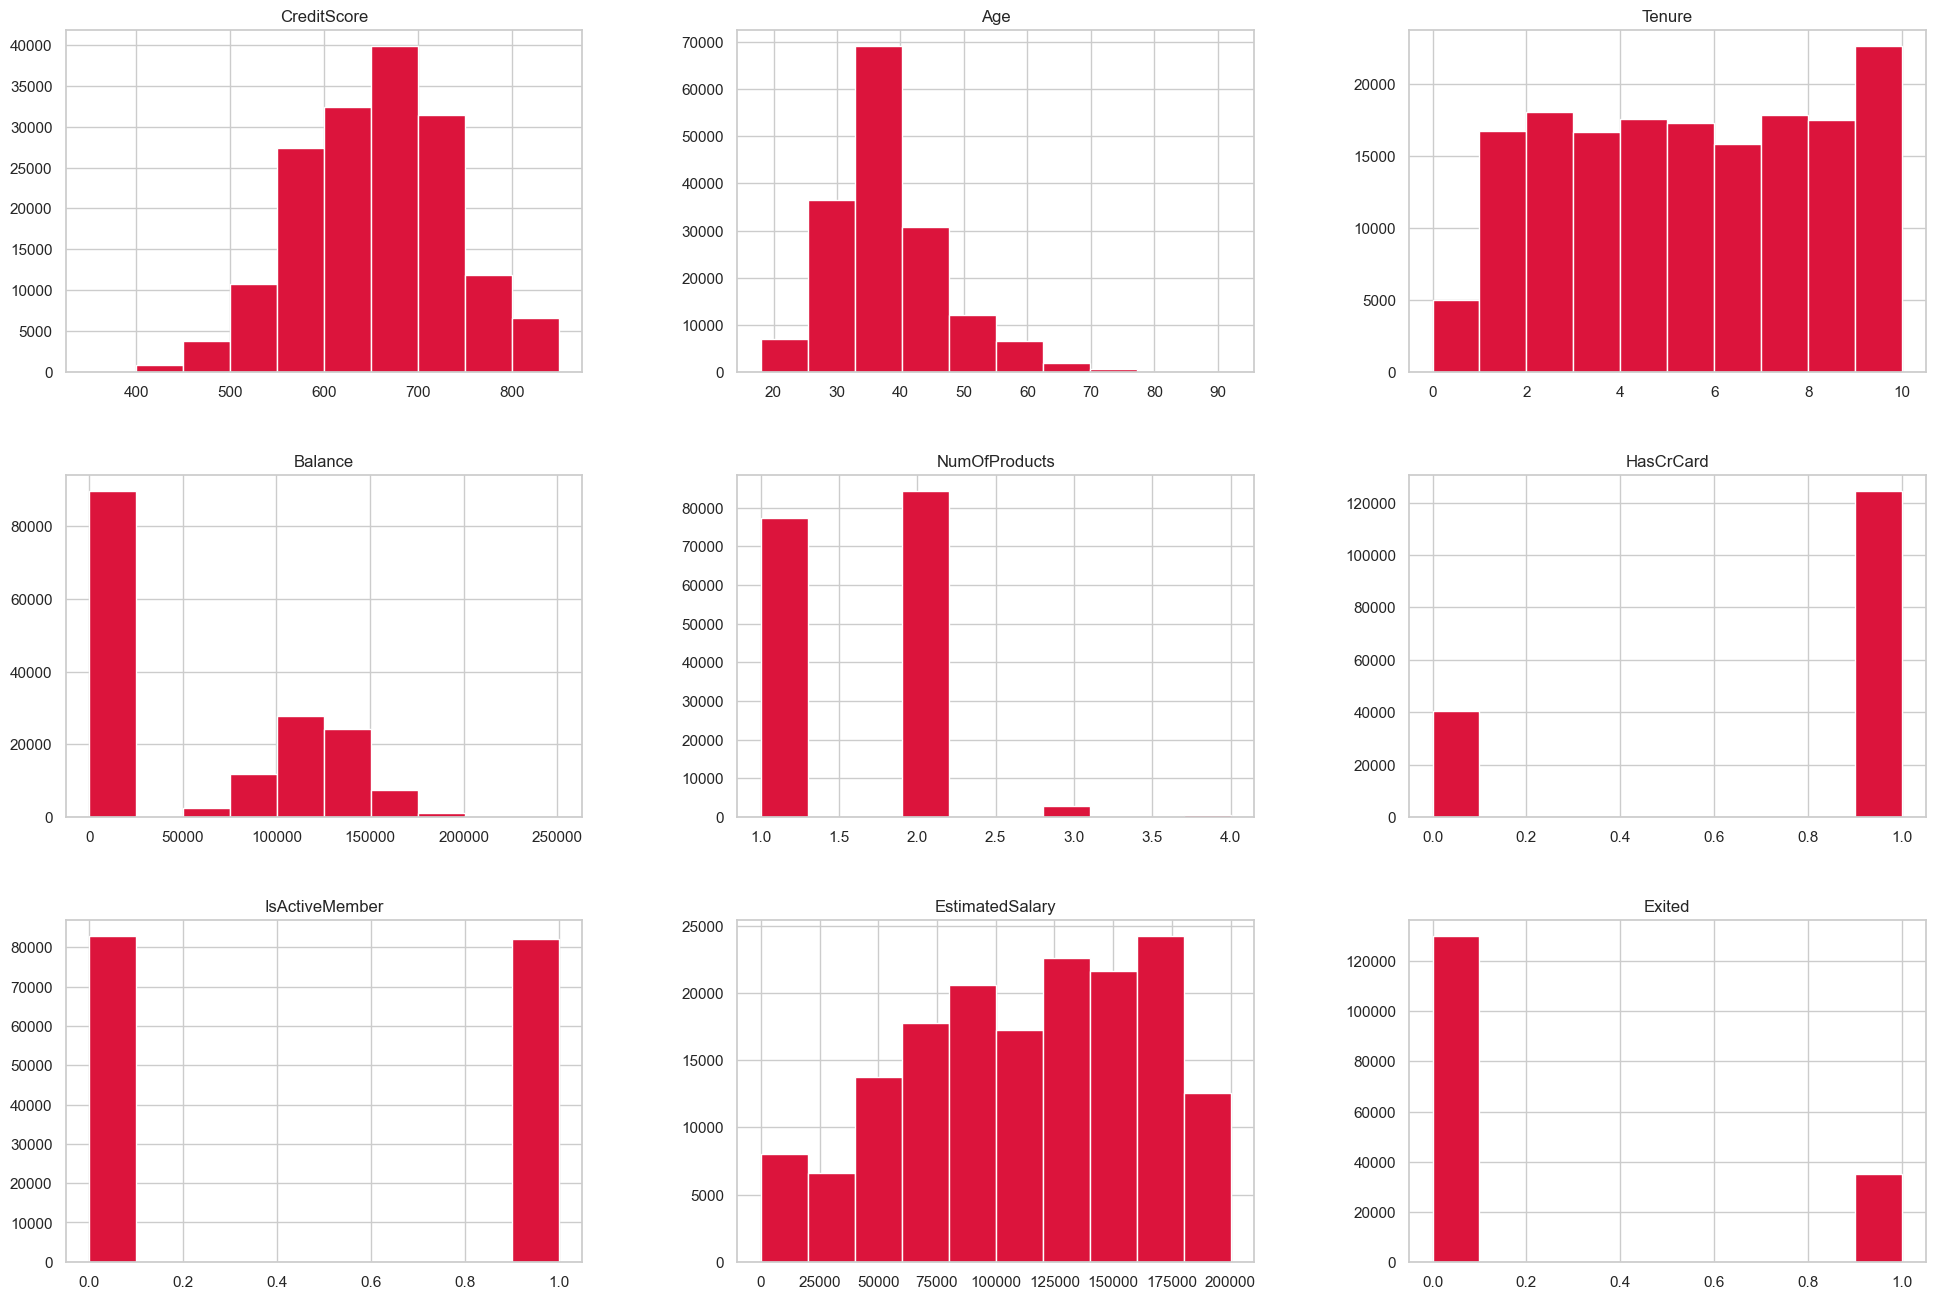

In [30]:
df.drop(columns=['id','Surname','CustomerId']).hist(figsize=(24,16),color='crimson');

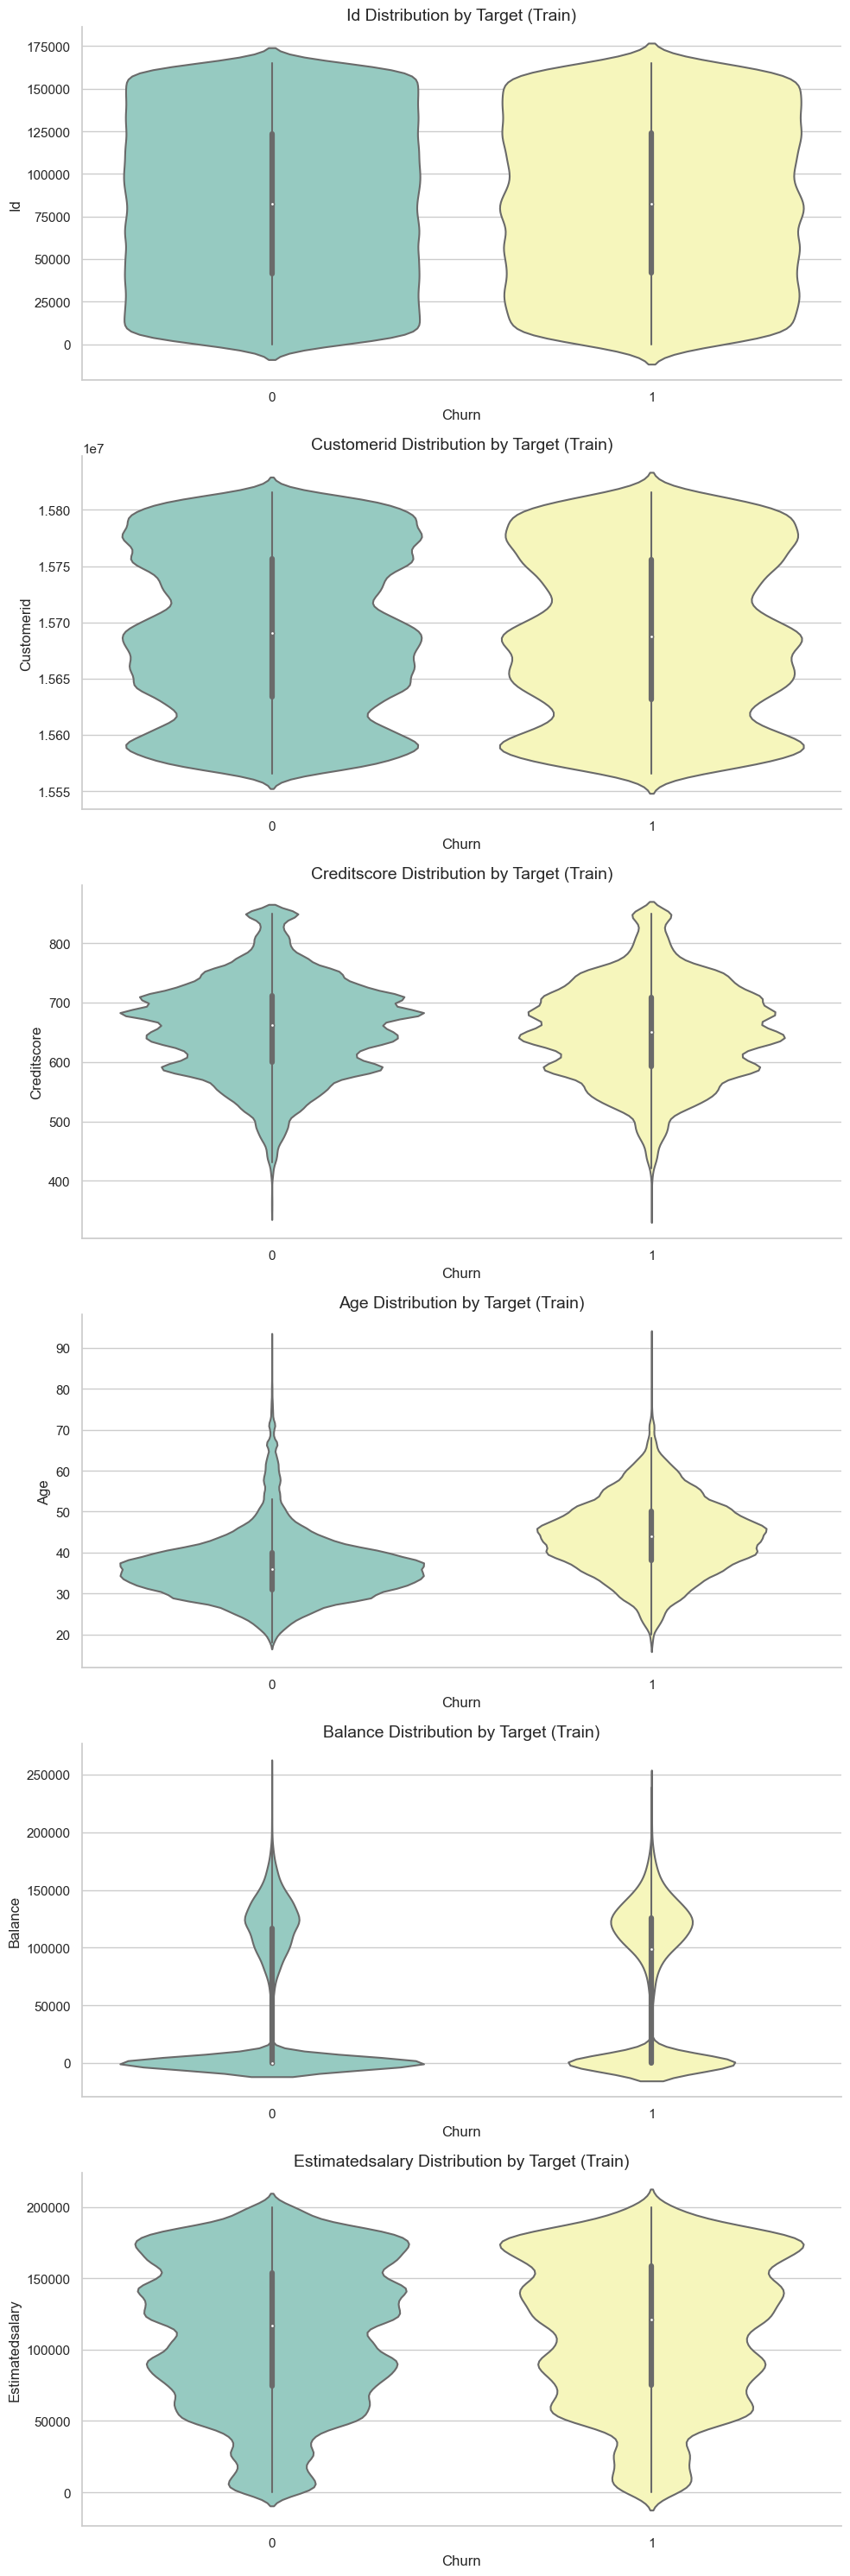

In [31]:
cont_cols = [f for f in df.columns if df[f].dtype != 'O' and df[f].nunique()>21]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 1, figsize=(10, 5 * n_rows))
sns.set_palette("Set3")
for i, col in enumerate(cont_cols):
    sns.violinplot(x='Exited', y=col, data=df, ax=axs[i])
    axs[i].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i].set_xlabel('Churn', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

### 2.3Categorical Features Analysis

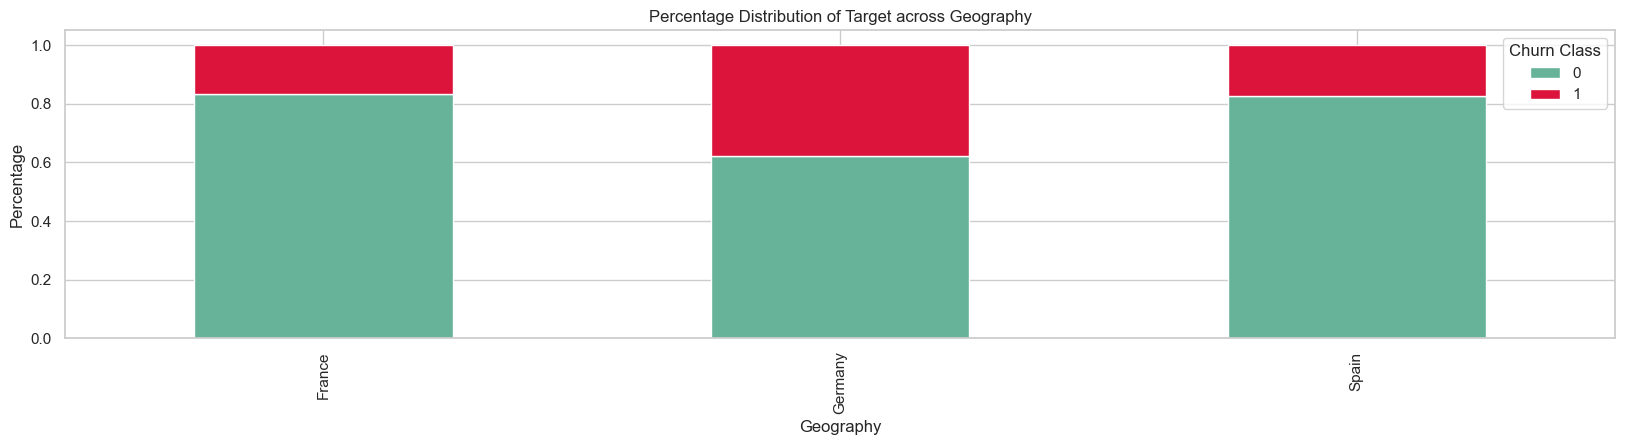

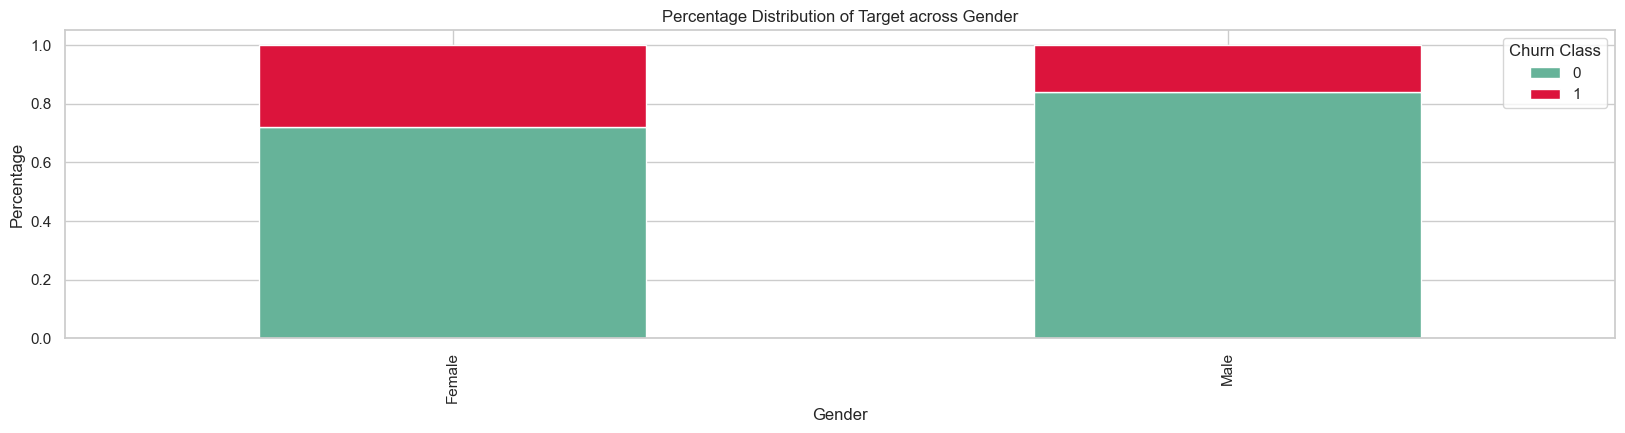

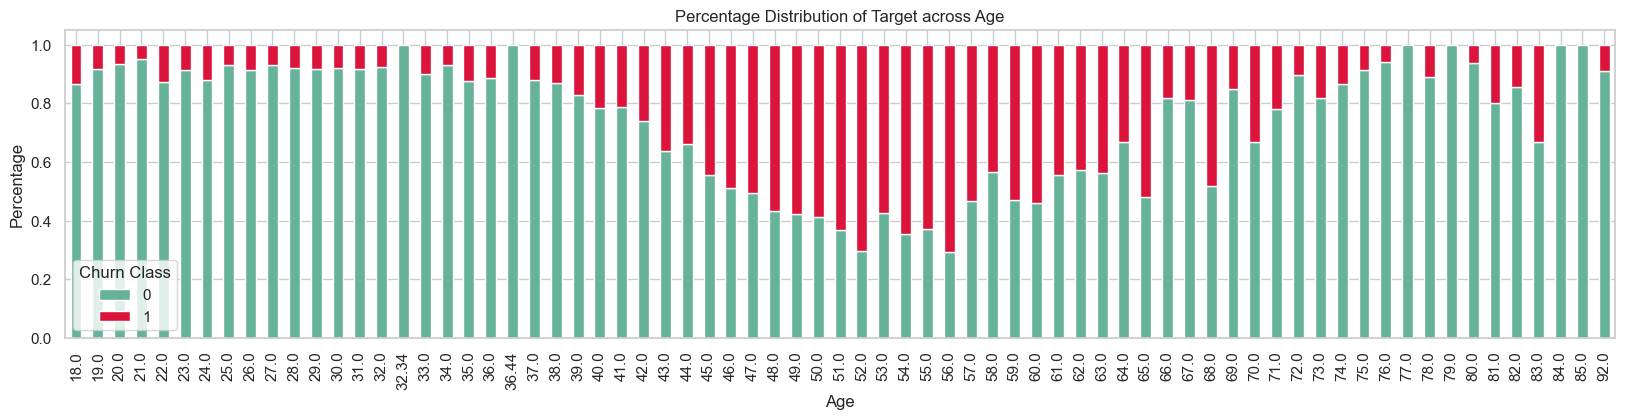

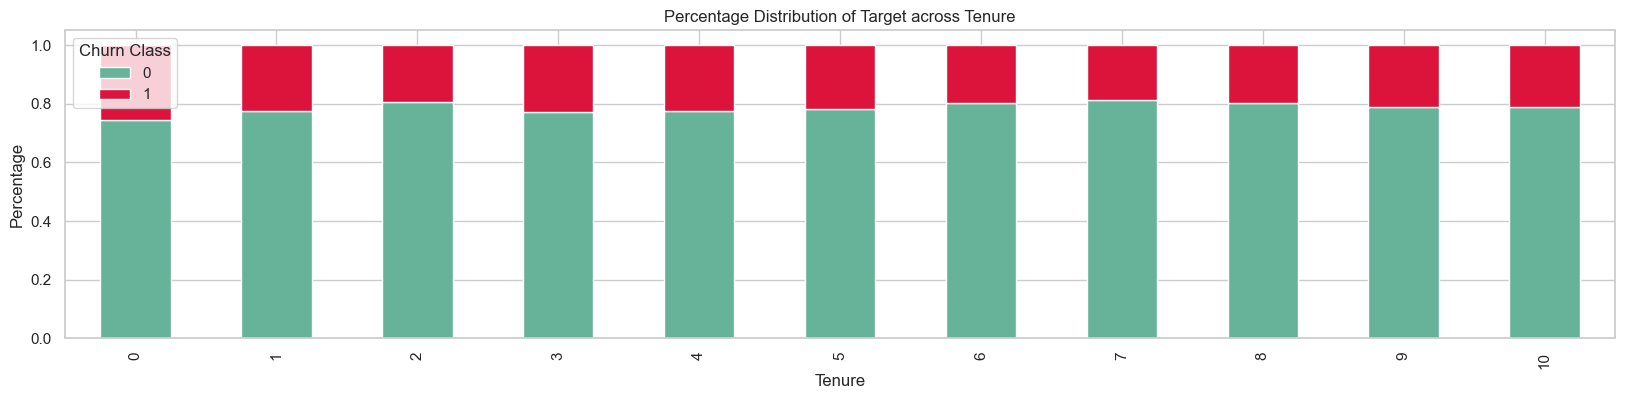

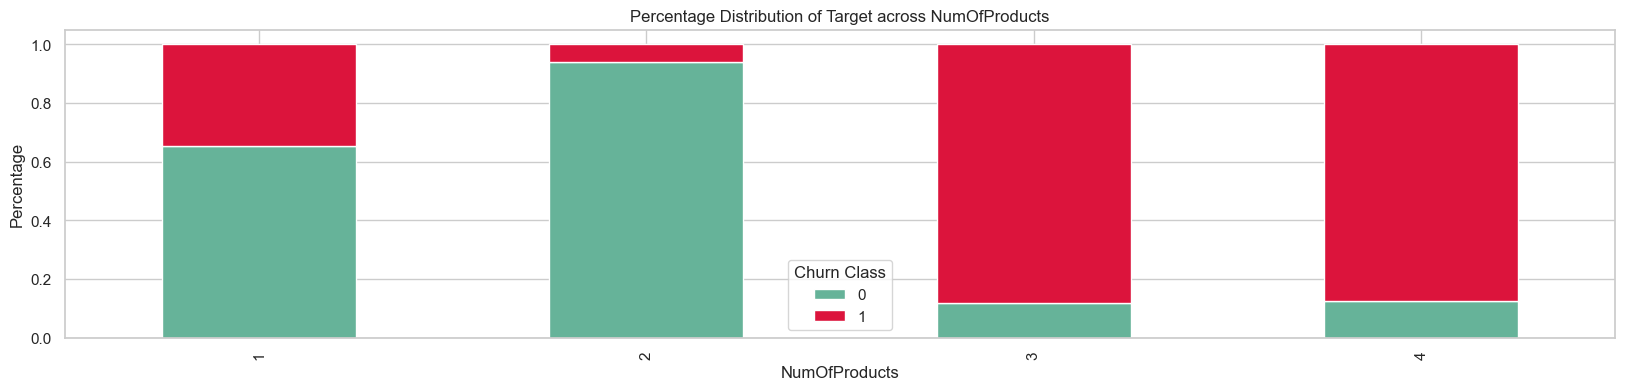

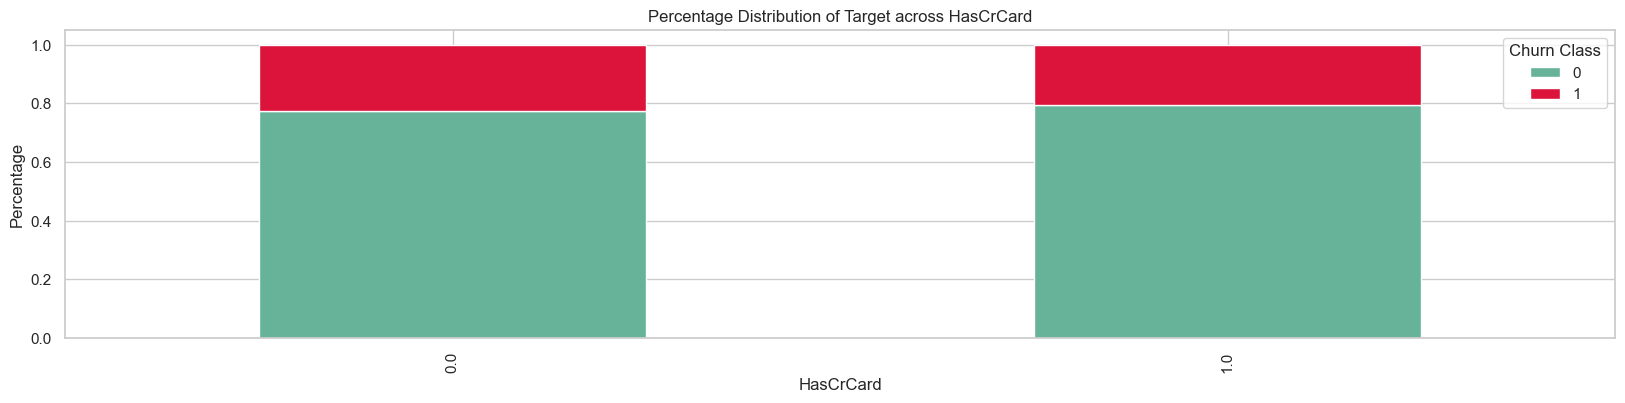

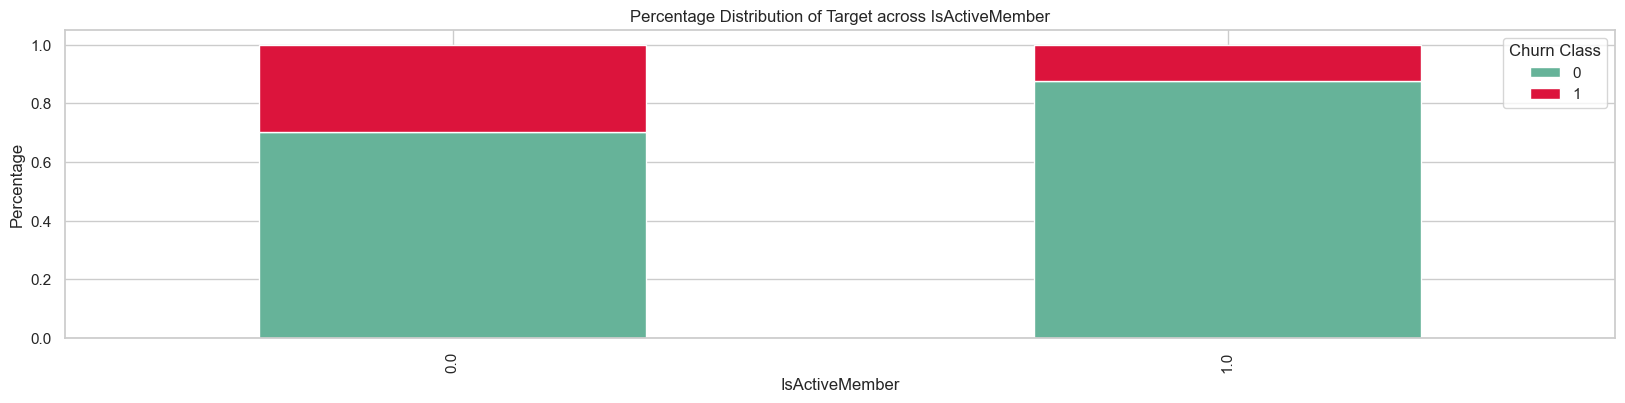

In [32]:
cat_cols = [f for f in test.columns if (df[f].dtype != 'O' and df[f].nunique() <100) or (df[f].dtype == 'O' and f not in ['Exited'] and df[f].nunique() <100) ]
custom_palette =(0.4, 0.7, 0.6), 'crimson'
for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['Exited'], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    plt.show()

In [33]:
df.drop(columns=['id','Surname','CustomerId']).describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# 3.Feature Engineering

In [34]:
target = df.pop('Exited')
data = pd.concat([df,test],axis=0)

# Drop unuseable data
data.drop(columns=['id','Surname','CustomerId'],inplace=True)

# Convert categorical data to int
data['Gender'] = data['Gender'].replace({'Male':0, 'Female':1})

data['Geography'] = data['Geography'].replace({'France':0, 'Spain':1, 'Germany':2})


from sklearn.preprocessing import StandardScaler
st = StandardScaler()
data_scaled = st.fit_transform(data)




In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


# Model

In [36]:
X = data.iloc[:df.shape[0]]
y = target 

test = data.iloc[df.shape[0]:]

In [37]:
# train test split 

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=42, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(132027, 10)
(132027,)
(33007, 10)
(33007,)


### CatBoost

In [100]:
params = {'n_estimators'          : 2048,
          'max_depth'             : 10,
          'learning_rate'         : 0.05,
          'subsample'             : 0.75,
          'reg_lambda'            : 1.00,
          'random_state'          : 578,
          'loss_function'         :'Logloss',
          'eval_metric'           :'Accuracy',
          'early_stopping_rounds' : 256,
         } 

cat_model = CatBoostClassifier(**params,silent=True)

cat_model.fit(X_train, y_train)

### Xgboost

In [102]:
import xgboost as xgb
params = {'n_estimators'          : 2048,
          'max_depth'             : 10,
          'learning_rate'         : 0.05,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 1.00,
          'gamma'                 : 1.00,
          'random_state'          : 578,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

xgb_model = xgb.XGBClassifier(**params,verbosity=0)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train,eval_set=eval_set,verbose=0)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=256,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2048, n_jobs=-1,
              num_parallel_tree=None, random_state=578, ...)

## Evaluate

In [103]:
from sklearn.metrics import confusion_matrix
# Predictions on the training set
train_predictions = cat_model.predict(X_train)
train_predictions_xg = xgb_model.predict(X_train)

# Predictions on the test set
test_predictions = cat_model.predict(X_test)
test_predictions_xg = xgb_model.predict(X_test)


# Evaluate accuracy on training set
train_accuracy = accuracy_score(y_train, train_predictions)
train_accuracy_xg = accuracy_score(y_train, train_predictions_xg)

# Evaluate accuracy on test set
test_accuracy = accuracy_score(y_test, test_predictions)
test_accuracy_xg = accuracy_score(y_test, test_predictions_xg)


# Confusion matrix on test set
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_xg = confusion_matrix(y_test, test_predictions_xg)


# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print('-------------------------')
print(f"Training Accuracy: {train_accuracy_xg:.4f}")
print(f"Test Accuracy: {test_accuracy_xg:.4f}")
print("Confusion Matrix:\n", conf_matrix_xg)

Training Accuracy: 0.9377
Test Accuracy: 0.8625
Confusion Matrix:
 [[24613  1439]
 [ 3099  3856]]
-------------------------
Training Accuracy: 0.8807
Test Accuracy: 0.8666
Confusion Matrix:
 [[24766  1286]
 [ 3116  3839]]


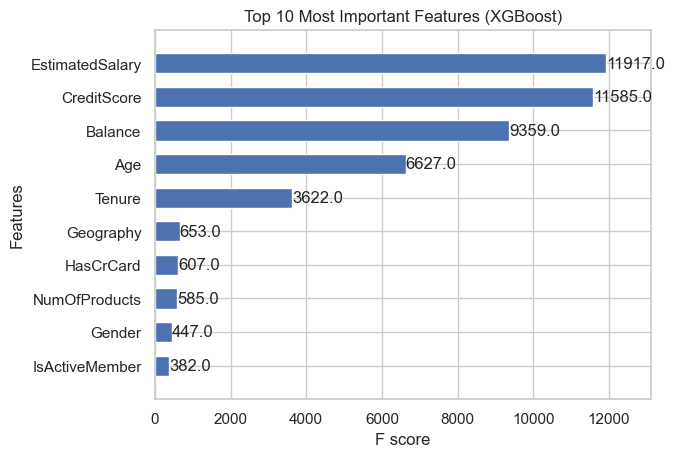

In [104]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.6)
plt.title('Top 10 Most Important Features (XGBoost)')
plt.show()

<Figure size 1000x600 with 0 Axes>

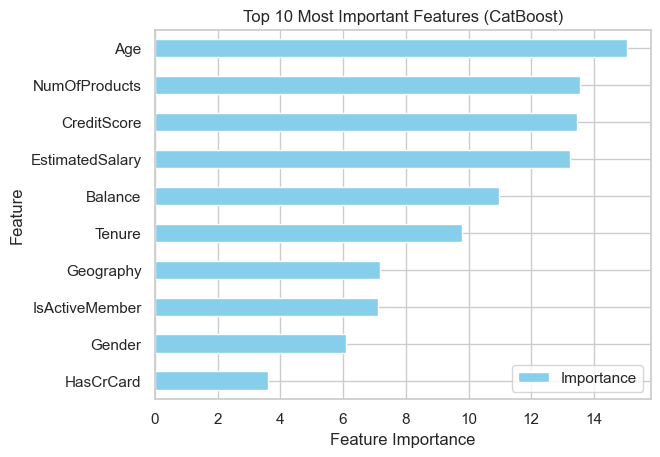

In [105]:
# Get feature importance
feature_importance = cat_model.get_feature_importance(type='FeatureImportance')

# Create a Pandas DataFrame with feature names and their importance scores
feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=1)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
feat_importance_df.head(10).plot(x='Feature', y='Importance', kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features (CatBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# Predict on the test file(using best model)

In [106]:
pred = cat_model.predict(test)

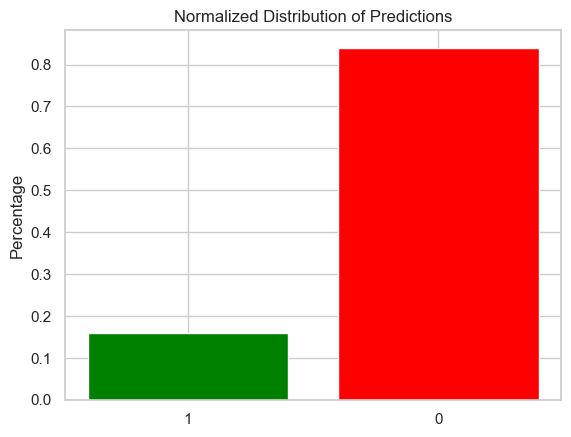

In [107]:
import numpy as np
survived_count = np.sum(pred == 1)
not_survived_count = np.sum(pred == 0)

total_predictions = len(pred)

# Normalize counts
survived_percentage = survived_count / total_predictions
not_survived_percentage = not_survived_count / total_predictions

# Create a bar plot
labels = ['1', '0']
values = [survived_percentage, not_survived_percentage]

plt.bar(labels, values, color=['green', 'red'])
plt.title('Normalized Distribution of Predictions')
plt.ylabel('Percentage')
plt.show()

## Submission

Text(0.5, 1.0, 'Prediction distribution')

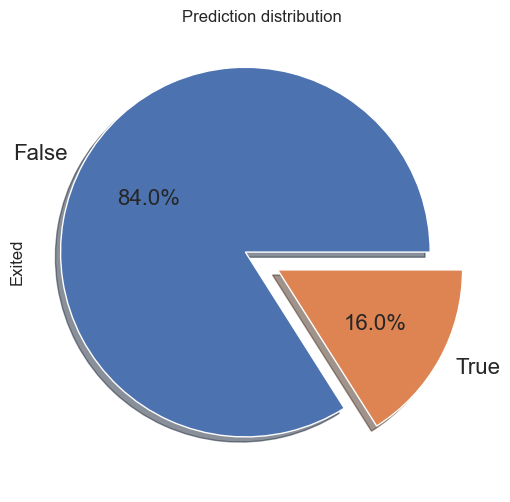

In [108]:
# Sample submission (to get right format)
sub=pd.read_csv('sample_submission.csv')

# Add predictions
sub['Exited']=pred

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Exited'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [109]:
# Output to csv
sub.to_csv('submission.csv', index=False)